In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import pandas as pd
from scipy.interpolate import RegularGridInterpolator
from scipy.optimize import brentq, least_squares
from scipy.stats import norm

plt.style.use("classic")

## Constants & Libraries


In [2]:
TENOR_MAPPING = {"M": 1 / 12, "Y": 1, "m": 1 / 12, "y": 1}


class AbstractBlack76Model:
    """
    A base class used to model Black-Scholes option model
    ...
    Parameters
    ----------
    F : float
        The forward price of the underlying asset
    K : float
        The strike price of the options
    discount_factor : float
        The "numeraire" discount factor of the model (i.e. PVBP, compounded discount factor)
    sigma : float
        Volatility
    T : float
        Maturity period (years)
    """

    def __init__(
        self,
        F: float,
        K: float,
        discount_factor: float,
        sigma: float,
        T: float,
    ):
        self.F = F
        self.K = K
        self.sigma = sigma
        self.T = T

        self.d1 = self._calculate_d1()
        self.d2 = self._calculate_d2()
        self.discount_factor = discount_factor

    def _calculate_d1(self) -> float:
        return (np.log(self.F / self.K) + self.sigma**2 / 2 * self.T) / (
            self.sigma * np.sqrt(self.T)
        )

    def _calculate_d2(self) -> float:
        return self.d1 - self.sigma * np.sqrt(self.T)


class VanillaBlack76Model(AbstractBlack76Model):
    def calculate_call_price(self) -> float:
        return self.discount_factor * (
            self.F * norm.cdf(self.d1) - self.K * norm.cdf(self.d2)
        )

    def calculate_put_price(self) -> float:
        return self.discount_factor * (
            -self.F * norm.cdf(-self.d1) + self.K * norm.cdf(-self.d2)
        )


class AbstractDisplacedDiffusionModel:
    """
    Displaced diffusion is extension of Black76 with an additional parameter beta
    ...
    Parameters
    ----------
    F : float
        The forward price of the underlying asset
    K : float
        The strike price of the options
    discount_factor : float
        The "numeraire" discount factor of the model (i.e. PVBP, compounded discount factor)
    sigma : float
        Volatility
    T : float
        Maturity period (years)
    beta : float
        Displaced diffusion model parameter (0,1], but lecture notes say [0,1]
        https://ink.library.smu.edu.sg/cgi/viewcontent.cgi?article=6976&context=lkcsb_research
    """

    def __init__(
        self,
        F: float,
        K: float,
        discount_factor: float,
        sigma: float,
        T: float,
        beta: float,
    ):
        self.F = F
        self.K = K
        self.sigma = sigma
        self.T = T
        self.beta = beta

        self.adjusted_F = self.F / self.beta
        self.adjusted_K = self.K + ((1 - self.beta) / self.beta) * self.F
        self.adjusted_sigma = self.sigma * self.beta
        self.discount_factor = discount_factor

        self.d1 = self._calculate_d1()
        self.d2 = self._calculate_d2()

    def _calculate_d1(self) -> float:
        return (
            np.log(self.adjusted_F / self.adjusted_K)
            + 0.5 * self.adjusted_sigma**2 * self.T
        ) / (self.adjusted_sigma * np.sqrt(self.T))

    def _calculate_d2(self) -> float:
        return self.d1 - self.adjusted_sigma * np.sqrt(self.T)


class VanillaDisplacedDiffusionModel(AbstractDisplacedDiffusionModel):
    def calculate_call_price(self) -> float:
        return self.discount_factor * (
            self.adjusted_F * norm.cdf(self.d1) - self.adjusted_K * norm.cdf(self.d2)
        )

    def calculate_put_price(self) -> float:
        return self.discount_factor * (
            self.adjusted_K * norm.cdf(-self.d2) - self.adjusted_F * norm.cdf(-self.d1)
        )


class VanillaOption:
    def black_model(
        self, F: float, K: float, discount_factor: float, sigma: float, T: float
    ) -> VanillaBlack76Model:
        return VanillaBlack76Model(F, K, discount_factor, sigma, T)

    def displaced_diffusion_model(
        self,
        F: float,
        K: float,
        discount_factor: float,
        sigma: float,
        T: float,
        beta: float,
    ) -> AbstractDisplacedDiffusionModel:
        return VanillaDisplacedDiffusionModel(F, K, discount_factor, sigma, T, beta)


def compute_pvbp(delta_tenor: npt.ArrayLike, discount_factor: npt.ArrayLike) -> float:
    return np.sum(delta_tenor * discount_factor)


def compute_forward_swap_rate(
    expiry: float,
    tenor: float,
    df_discount_factors: pd.DataFrame,
    floating_leg_period: float = 1,
    fixed_leg_period: float = 1,
) -> float:
    swap_end_time = expiry + tenor
    floating_leg_term = np.arange(
        expiry + floating_leg_period,
        swap_end_time + floating_leg_period,
        floating_leg_period,
    )
    fixed_leg_terms = np.arange(
        expiry + fixed_leg_period,
        swap_end_time + fixed_leg_period,
        fixed_leg_period,
    )
    floating_leg_pv = np.sum(
        floating_leg_period
        * df_discount_factors.loc[floating_leg_term, "Forward LIBOR"]
        * df_discount_factors.loc[floating_leg_term, "Discount Factor OIS"]
    )
    fixed_leg_pv = np.sum(
        fixed_leg_period
        * df_discount_factors.loc[fixed_leg_terms, "Discount Factor OIS"]
    )
    return floating_leg_pv / fixed_leg_pv

## Data Input


In [3]:
fixed_leg_period = 0.5
floating_leg_period = 0.5

## Data Import


In [4]:
df_swaption = pd.read_excel("../data/IR data.xlsx", sheet_name="Swaption", header=2)
df_swaption

,Expiry,Tenor,-200bps,-150bps,-100bps,-50bps,-25bps,ATM,+25bps,+50bps,+100bps,+150bps,+200bps
0,1Y,1Y,91.570,62.030,44.130,31.224,26.182,22.50,20.96,21.40,24.34,27.488,30.297
1,1Y,2Y,83.270,61.240,46.570,35.807,31.712,28.72,27.12,26.84,28.51,31.025,33.523
2,1Y,3Y,73.920,56.870,44.770,35.745,32.317,29.78,28.29,27.80,28.77,30.725,32.833
3,1Y,5Y,55.190,44.640,36.510,30.242,27.851,26.07,24.98,24.56,25.12,26.536,28.165
4,1Y,10Y,41.180,35.040,30.207,26.619,25.351,24.47,23.98,23.82,24.25,25.204,26.355
5,5Y,1Y,67.800,49.090,38.400,31.485,29.060,27.26,26.04,25.32,24.94,25.320,25.980
6,5Y,2Y,57.880,46.410,39.033,33.653,31.531,29.83,28.56,27.65,26.71,26.540,26.760
7,5Y,3Y,53.430,44.440,38.180,33.437,31.536,29.98,28.76,27.82,26.67,26.200,26.150
8,5Y,5Y,41.990,36.524,32.326,29.005,27.677,26.60,25.73,25.02,24.06,23.570,23.400
9,5Y,10Y,34.417,30.948,28.148,25.954,25.136,24.51,23.99,23.56,22.91,22.490,22.250


In [5]:
df_swap_rates = pd.read_csv(
    "../bootstrap_swap_curve/output/part_1_swap_rates.csv", index_col=0
)
df_swap_rates

,Expiry,Tenor,Swap Rate
0,1,1,0.032007
1,1,2,0.033259
2,1,3,0.034011
3,1,5,0.035255
4,1,10,0.038428
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040072
8,5,5,0.041093
9,5,10,0.043634


In [6]:
df_discount_factors = pd.read_csv(
    "../bootstrap_swap_curve/output/part_1_bootstrapped_discount_factors.csv",
    index_col=0,
)

## Data Formatting


In [7]:
def format_swaption_data(df_swaption: pd.DataFrame) -> pd.DataFrame:
    df_swaption_formatted = df_swaption.copy()
    df_swaption_formatted["Expiry"] = (
        df_swaption_formatted["Expiry"]
        .str.extract(r"(\d+)([myMY])")
        .apply(lambda x: int(x[0]) * TENOR_MAPPING[x[1]], axis=1)
    )
    df_swaption_formatted["Tenor"] = (
        df_swaption_formatted["Tenor"]
        .str.extract(r"(\d+)([myMY])")
        .apply(lambda x: int(x[0]) * TENOR_MAPPING[x[1]], axis=1)
    )
    df_swaption_formatted = df_swaption_formatted.set_index(["Expiry", "Tenor"])
    return df_swaption_formatted.copy()

In [8]:
df_swaption = format_swaption_data(df_swaption)

## Pre-computation


In [9]:
vanilla_option = VanillaOption()


def implied_volatility(
    F: float,
    K: float,
    discount_factor: float,
    price: float,
    T: float,
    options_type: str,
) -> float:
    try:
        b76_model = lambda x: vanilla_option.black_model(F, K, discount_factor, x, T)
        if options_type.lower() == "payer":
            implied_vol = brentq(
                lambda x: price - b76_model(x).calculate_call_price(), 1e-12, 10.0
            )
        elif options_type.lower() == "receiver":
            implied_vol = brentq(
                lambda x: price - b76_model(x).calculate_put_price(), 1e-12, 10.0
            )
        else:
            raise NameError("Payoff type not recognized")
    except Exception:
        implied_vol = 0

    return implied_vol

In [10]:
def compute_pvbp_with_df_ois(
    expiry: float, tenor: float, fixed_leg_period: float, df_ois: pd.DataFrame
):
    fixed_leg_terms = np.arange(
        expiry + fixed_leg_period, expiry + tenor + fixed_leg_period, fixed_leg_period
    )
    delta_tenors = np.empty(len(fixed_leg_terms))
    delta_tenors.fill(fixed_leg_period)
    discount_factors = df_ois.loc[fixed_leg_terms, "Discount Factor OIS"].values
    return compute_pvbp(delta_tenors, discount_factors)


# Compute PVBP for each forward swap rates
df_swap_rates["PVBP"] = df_swap_rates.apply(
    lambda x: compute_pvbp_with_df_ois(
        x["Expiry"], x["Tenor"], fixed_leg_period, df_discount_factors
    ),
    axis=1,
)

In [11]:
def convert_vol_bps_to_float(value):
    try:
        if "bps" in value:
            return float(value.replace("bps", ""))
        else:
            # If 'ATM' is encountered, you may handle it as per your requirement.
            return 0
    except ValueError:
        # Handle the case where the conversion to float is not possible
        return float("nan")


vol_rates_change = np.array(
    [convert_vol_bps_to_float(x) * 0.01 / 100 for x in df_swaption.columns]
)

## Displaced-Diffusion Model


In [12]:
def calculate_displaced_diffusion_price(
    F: float,
    strike: float,
    discount_factor: float,
    sigma: float,
    T: float,
    beta,
    options_type: str,
):
    if options_type == "payer":
        price = vanilla_option.displaced_diffusion_model(
            F, strike, discount_factor, sigma, T, beta
        ).calculate_call_price()
    else:
        price = vanilla_option.displaced_diffusion_model(
            F, strike, discount_factor, sigma, T, beta
        ).calculate_put_price()
    return price


def calculate_displaced_diffusion_implied_vol(
    F: float,
    strike: float,
    discount_factor: float,
    sigma: float,
    T: float,
    beta,
    options_type: str,
) -> float:
    price = calculate_displaced_diffusion_price(
        F, strike, discount_factor, sigma, T, beta, options_type
    )
    implied_vol = implied_volatility(F, strike, discount_factor, price, T, options_type)
    return implied_vol

In [13]:
def calculate_DD_vol_err(x, strikes, vols, F, discount_factor, sigma, T, options_type):
    err = 0.0
    for i, vol in enumerate(vols):
        implied_vol = calculate_displaced_diffusion_implied_vol(
            F, strikes[i], discount_factor, sigma, T, x[0], options_type[i]
        )

        err += (vol - implied_vol) ** 2
    return err

In [14]:
ddm_parameters = {}
swaption_calibrated_ddm_vols = {}
for index, row in df_swap_rates.iterrows():
    expiry, tenor, swap_rate, pvbp = (
        row["Expiry"],
        row["Tenor"],
        row["Swap Rate"],
        row["PVBP"],
    )

    strikes = swap_rate + vol_rates_change
    vols = df_swaption.loc[(expiry, tenor)].values / 100
    options_types = np.array(
        ["receiver" if x < swap_rate else "payer" for x in strikes]
    )

    F = swap_rate
    discount_factor = pvbp
    T = expiry
    sigma = df_swaption.loc[(expiry, tenor)]["ATM"] / 100

    initial_guess = [0.96]  # beta
    res = least_squares(
        lambda x: calculate_DD_vol_err(
            x,
            strikes,
            vols,
            F,
            discount_factor,
            sigma,
            T,
            options_types,
        ),
        initial_guess,
        bounds=(0, 1),
    )

    beta = res.x[0]
    calibrated_vols = []
    for index, strike in enumerate(strikes):
        calibrated_vols.append(
            calculate_displaced_diffusion_implied_vol(
                F, strike, discount_factor, sigma, T, beta, options_types[index]
            )
        )

    key = "{}Yx{}Y".format(expiry, tenor)
    ddm_parameters[key] = {
        "expiry": expiry,
        "tenor": tenor,
        "sigma": sigma,
        "beta": beta,
    }
    swaption_calibrated_ddm_vols[key] = calibrated_vols

In [15]:
df_ddm_parameters = pd.DataFrame(ddm_parameters.values(), index=ddm_parameters.keys())
df_ddm_parameters.index.name = "Swaption"
df_ddm_sigma = df_ddm_parameters.pivot(index="expiry", columns="tenor", values="sigma")
df_ddm_beta = df_ddm_parameters.pivot(index="expiry", columns="tenor", values="beta")

In [16]:
print("DDM Sigma Parameters:")
df_ddm_sigma

DDM Sigma Parameters:


tenor,1.0,2.0,3.0,5.0,10.0
expiry,,,,,
1.0,0.2250,0.2872,0.2978,0.2607,0.2447
5.0,0.2726,0.2983,0.2998,0.2660,0.2451
10.0,0.2854,0.2928,0.2940,0.2674,0.2437


In [17]:
print("DDM Beta Parameters:")
df_ddm_beta

DDM Beta Parameters:


tenor,1.0,2.0,3.0,5.0,10.0
expiry,,,,,
1.0,2.972551e-08,7.343053e-12,1.335780e-09,7.036454e-08,6.306188e-07
5.0,6.951658e-10,5.157503e-07,5.019084e-07,5.108234e-07,5.412154e-02
10.0,2.432210e-09,3.411440e-06,5.232234e-08,7.919070e-06,1.972148e-04


## SABR Model


In [18]:
def SABR_model(F, K, T, alpha, beta, rho, nu):
    X = K
    # if K is at-the-money-forward
    if abs(F - K) < 1e-12:
        numer1 = (((1 - beta) ** 2) / 24) * alpha * alpha / (F ** (2 - 2 * beta))
        numer2 = 0.25 * rho * beta * nu * alpha / (F ** (1 - beta))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        VolAtm = alpha * (1 + (numer1 + numer2 + numer3) * T) / (F ** (1 - beta))
        sabrsigma = VolAtm
    else:
        z = (nu / alpha) * ((F * X) ** (0.5 * (1 - beta))) * np.log(F / X)
        zhi = np.log((((1 - 2 * rho * z + z * z) ** 0.5) + z - rho) / (1 - rho))
        numer1 = (((1 - beta) ** 2) / 24) * ((alpha * alpha) / ((F * X) ** (1 - beta)))
        numer2 = 0.25 * rho * beta * nu * alpha / ((F * X) ** ((1 - beta) / 2))
        numer3 = ((2 - 3 * rho * rho) / 24) * nu * nu
        numer = alpha * (1 + (numer1 + numer2 + numer3) * T) * z
        denom1 = ((1 - beta) ** 2 / 24) * (np.log(F / X)) ** 2
        denom2 = (((1 - beta) ** 4) / 1920) * ((np.log(F / X)) ** 4)
        denom = ((F * X) ** ((1 - beta) / 2)) * (1 + denom1 + denom2) * zhi
        sabrsigma = numer / denom

    return sabrsigma


def calculate_SABR_vol_err(x, strikes, vols, F, T, beta):
    err = 0.0
    for i, vol in enumerate(vols):
        err += (vol - SABR_model(F, strikes[i], T, x[0], beta, x[1], x[2])) ** 2
    return err

In [19]:
beta = 0.9
sabr_parameters = {}
swaption_calibrated_sabr_vols = {}

for index, row in df_swap_rates.iterrows():
    expiry, tenor, swap_rate = (
        row["Expiry"],
        row["Tenor"],
        row["Swap Rate"],
    )

    strikes = swap_rate + vol_rates_change
    vols = df_swaption.loc[(expiry, tenor)].values / 100

    F = swap_rate
    T = expiry

    initial_guess = [0.2, -0.5, 1]  # alpha, rho, nu
    res = least_squares(
        lambda x: calculate_SABR_vol_err(
            x,
            strikes,
            vols,
            F,
            T,
            beta,
        ),
        initial_guess,
        max_nfev=3000,
    )

    alpha, rho, nu = res.x
    calibrated_vols = []
    for index, strike in enumerate(strikes):
        calibrated_vols.append(SABR_model(F, strike, T, alpha, beta, rho, nu))

    key = "{}Yx{}Y".format(expiry, tenor)
    sabr_parameters[key] = {
        "expiry": expiry,
        "tenor": tenor,
        "alpha": alpha,
        "beta": beta,
        "rho": rho,
        "nu": nu,
    }

    swaption_calibrated_sabr_vols[key] = calibrated_vols

In [20]:
df_sabr_parameters = pd.DataFrame(
    sabr_parameters.values(), index=sabr_parameters.keys()
)
df_sabr_parameters.index.name = "Swaption"
df_sabr_alpha = df_sabr_parameters.pivot(
    index="expiry", columns="tenor", values="alpha"
)
df_sabr_beta = df_sabr_parameters.pivot(index="expiry", columns="tenor", values="beta")
df_sabr_rho = df_sabr_parameters.pivot(index="expiry", columns="tenor", values="rho")
df_sabr_nu = df_sabr_parameters.pivot(index="expiry", columns="tenor", values="nu")

In [21]:
print("SABR Alpha Parameters:")
df_sabr_alpha

SABR Alpha Parameters:


tenor,1.0,2.0,3.0,5.0,10.0
expiry,,,,,
1.0,0.139074,0.184651,0.196851,0.178058,0.170138
5.0,0.166619,0.199534,0.210292,0.190256,0.174848
10.0,0.178247,0.196313,0.208244,0.202510,0.179925


In [22]:
print("SABR Beta Parameters:")
df_sabr_beta

SABR Beta Parameters:


tenor,1.0,2.0,3.0,5.0,10.0
expiry,,,,,
1.0,0.9,0.9,0.9,0.9,0.9
5.0,0.9,0.9,0.9,0.9,0.9
10.0,0.9,0.9,0.9,0.9,0.9


In [23]:
print("SABR Rho Parameters:")
df_sabr_rho

SABR Rho Parameters:


tenor,1.0,2.0,3.0,5.0,10.0
expiry,,,,,
1.0,-0.633223,-0.525114,-0.482848,-0.414489,-0.259059
5.0,-0.585669,-0.547030,-0.549571,-0.506883,-0.416088
10.0,-0.548313,-0.547531,-0.553567,-0.566401,-0.507487


In [24]:
print("SABR Nu Parameters:")
df_sabr_nu

SABR Nu Parameters:


tenor,1.0,2.0,3.0,5.0,10.0
expiry,,,,,
1.0,2.049417,1.677374,1.438124,1.064846,0.790670
5.0,1.340429,1.062005,0.936691,0.674503,0.511068
10.0,1.010145,0.928631,0.871661,0.723785,0.581846


### Combined Plots


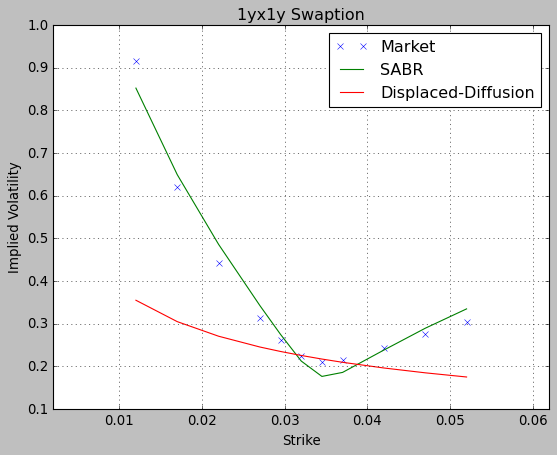

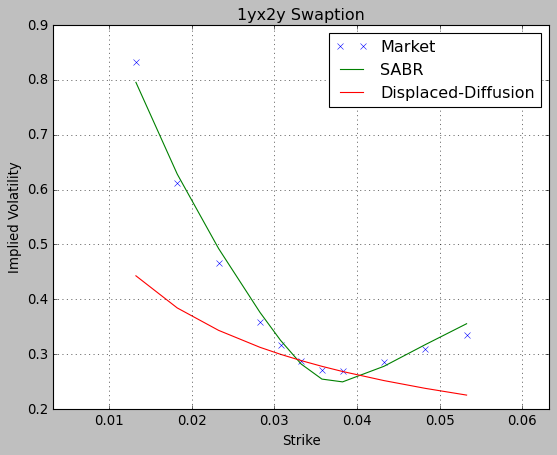

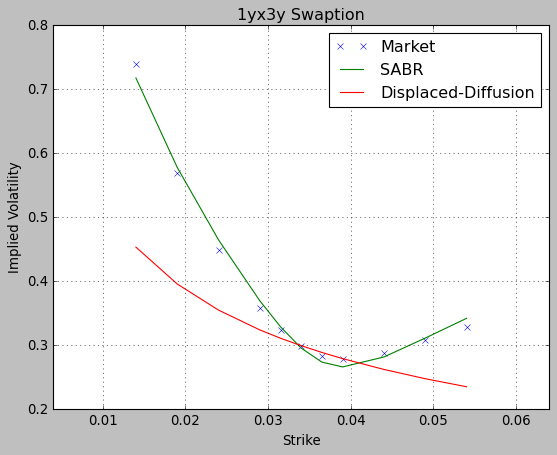

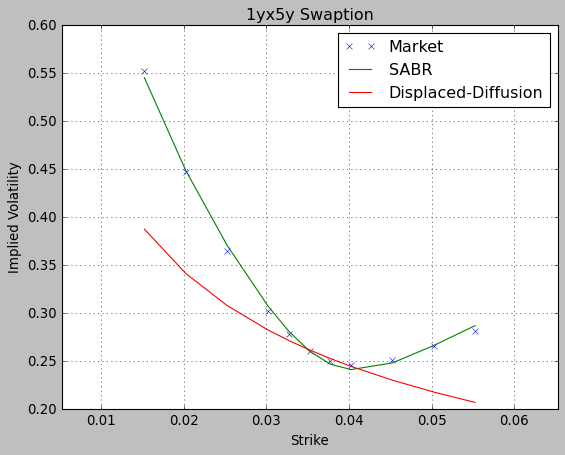

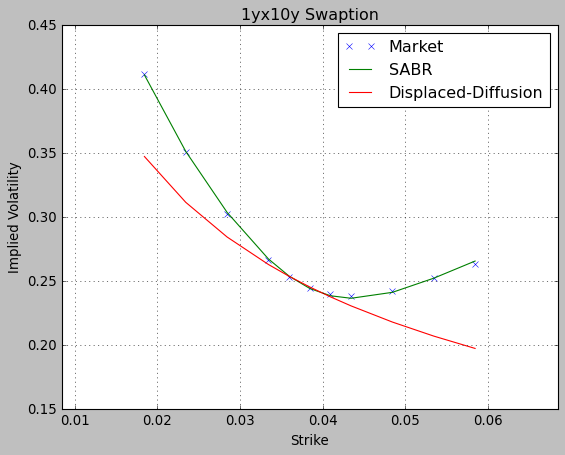

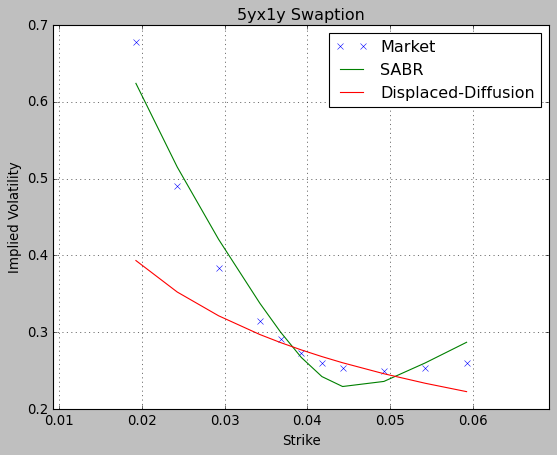

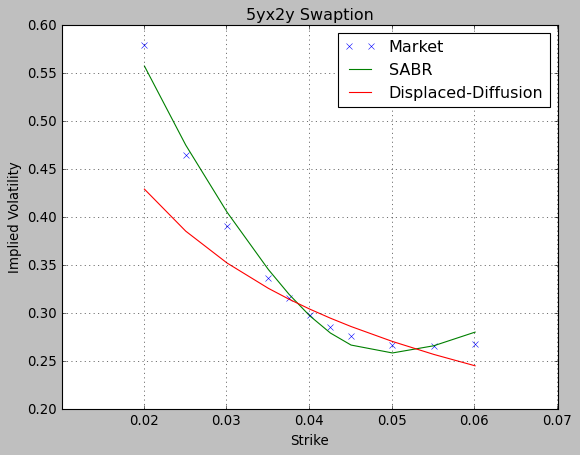

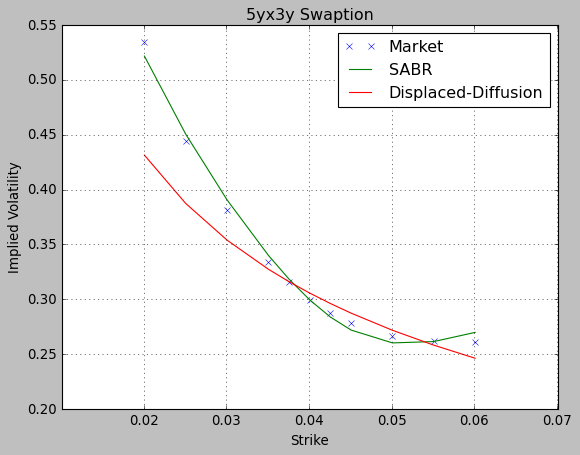

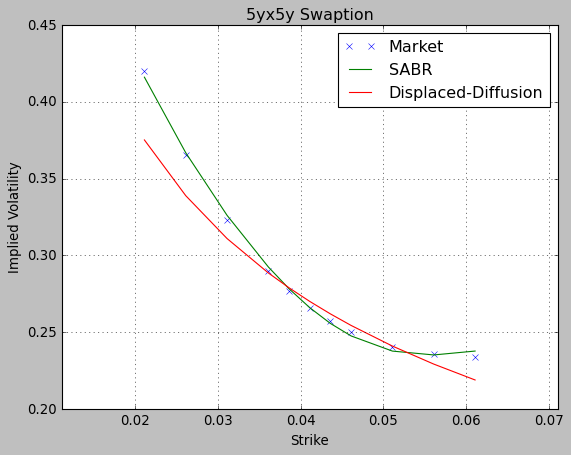

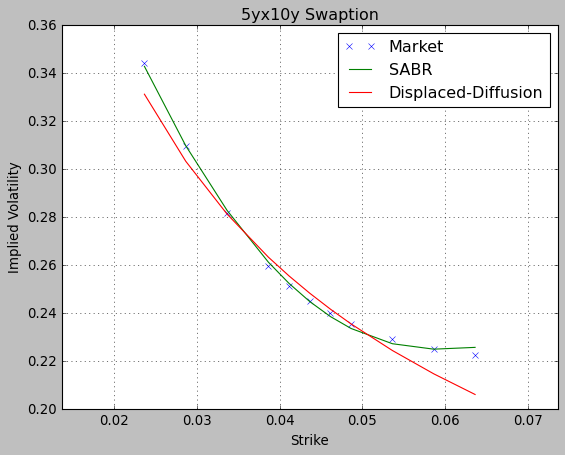

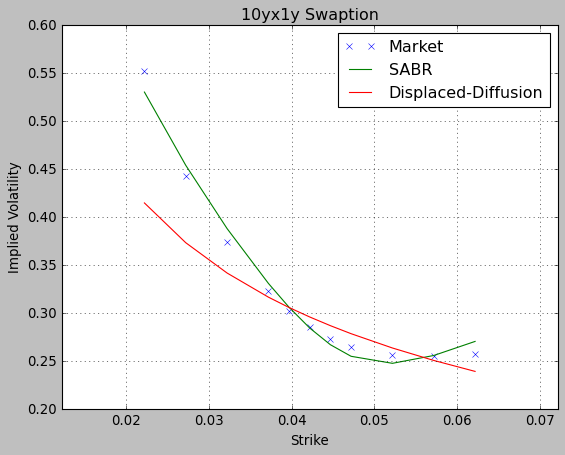

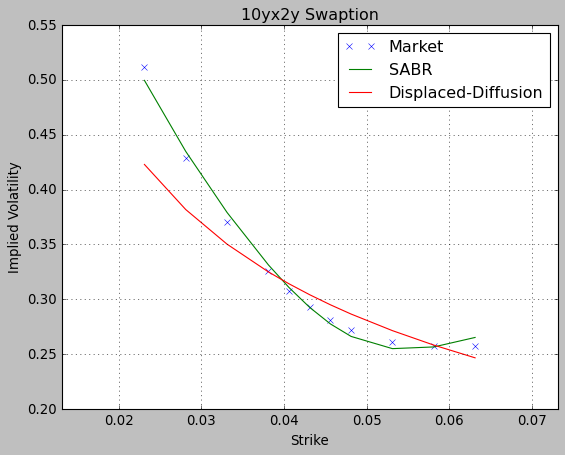

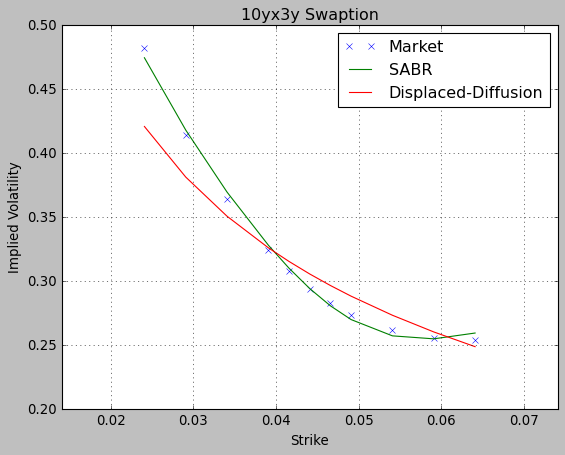

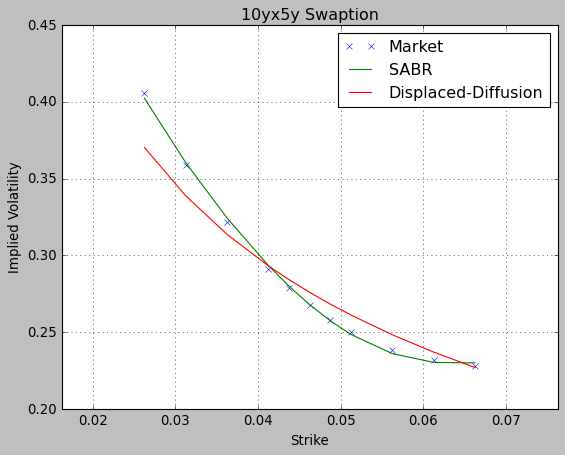

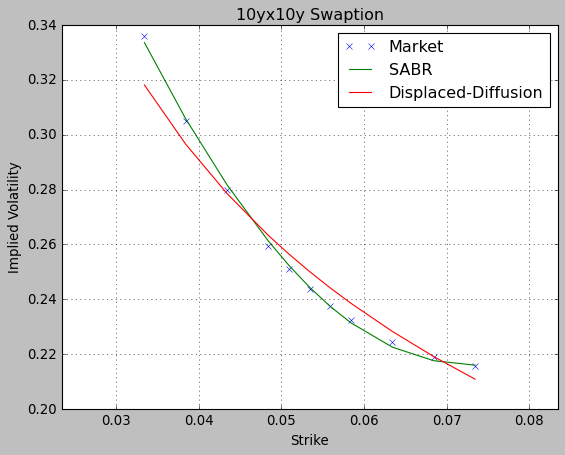

In [25]:
for index, row in df_swap_rates.iterrows():
    expiry, tenor, swap_rate = (
        row["Expiry"],
        row["Tenor"],
        row["Swap Rate"],
    )
    strikes = swap_rate + vol_rates_change

    dic_key = "{}Yx{}Y".format(expiry, tenor)
    calibrated_sabr_vols = swaption_calibrated_sabr_vols[dic_key]
    calibrated_dd_vols = swaption_calibrated_ddm_vols[dic_key]
    actual_vols = df_swaption.loc[(expiry, tenor)].values / 100

    title = "{}yx{}y Swaption".format(int(expiry), int(tenor))
    plt.title(title)
    plt.plot(strikes, actual_vols, "x", label="Market")
    plt.plot(strikes, calibrated_sabr_vols, label="SABR")
    plt.plot(strikes, calibrated_dd_vols, label="Displaced-Diffusion")

    plt.xlim(min(strikes) - 0.01, max(strikes) + 0.01)
    plt.grid()
    plt.xlabel("Strike")
    plt.ylabel("Implied Volatility")
    plt.legend()
    plt.savefig("./output/part_2_swaption_{}.png".format(title))
    plt.show()

## Swaptions Pricing


In [26]:
strikes = [0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08]
swaptions_to_price = [
    {"expiry": 2, "tenor": 10, "type": "payer"},
    {"expiry": 8, "tenor": 10, "type": "receiver"},
]

In [27]:
# DDM
ddm_beta_interp = RegularGridInterpolator(
    (df_ddm_beta.index, df_ddm_beta.columns), df_ddm_beta.values, method="linear"
)
ddm_sigma_interp = RegularGridInterpolator(
    (df_ddm_sigma.index, df_ddm_sigma.columns), df_ddm_sigma.values, method="linear"
)

# SABR
sabr_alpha_interp = RegularGridInterpolator(
    (df_sabr_alpha.index, df_sabr_alpha.columns), df_sabr_alpha.values, method="linear"
)
sabr_beta_interp = RegularGridInterpolator(
    (df_sabr_beta.index, df_sabr_beta.columns), df_sabr_beta.values, method="linear"
)
sabr_rho_interp = RegularGridInterpolator(
    (df_sabr_rho.index, df_sabr_rho.columns), df_sabr_rho.values, method="linear"
)
sabr_nu_interp = RegularGridInterpolator(
    (df_sabr_nu.index, df_sabr_nu.columns), df_sabr_nu.values, method="linear"
)

In [28]:
pricing_results = []
for swaption in swaptions_to_price:
    expiry, tenor, swaption_type = (
        swaption["expiry"],
        swaption["tenor"],
        swaption["type"],
    )
    pvbp = compute_pvbp_with_df_ois(
        expiry, tenor, fixed_leg_period, df_discount_factors
    )
    F = compute_forward_swap_rate(
        expiry, tenor, df_discount_factors, floating_leg_period, fixed_leg_period
    )

    point_to_interp = (expiry, tenor)
    ddm_params = {
        "sigma": ddm_sigma_interp(point_to_interp),
        "beta": ddm_beta_interp(point_to_interp),
    }
    sabr_params = {
        "alpha": sabr_alpha_interp(point_to_interp),
        "beta": sabr_beta_interp(point_to_interp),
        "rho": sabr_rho_interp(point_to_interp),
        "nu": sabr_nu_interp(point_to_interp),
    }

    for strike in strikes:
        dd_price = calculate_displaced_diffusion_price(
            F,
            strike,
            pvbp,
            ddm_params["sigma"],
            tenor,
            ddm_params["beta"],
            swaption_type,
        )

        sabr_sigma = SABR_model(
            F,
            strike,
            tenor,
            sabr_params["alpha"],
            sabr_params["beta"],
            sabr_params["rho"],
            sabr_params["nu"],
        )
        black_sabr_model = vanilla_option.black_model(
            F, strike, discount_factor, sabr_sigma, T
        )
        sabr_price = (
            black_sabr_model.calculate_call_price()
            if swaption_type == "payer"
            else black_sabr_model.calculate_put_price()
        )

        pricing_results.append(
            {
                "Swaption Type": swaption_type,
                "Expiry": expiry,
                "Tenor": tenor,
                "Strike": strike,
                "DD Price": dd_price,
                "SABR Price": sabr_price,
            }
        )

In [29]:
df_swaption_pricing_results = pd.DataFrame(pricing_results)
df_swaption_pricing_results

,Swaption Type,Expiry,Tenor,Strike,DD Price,SABR Price
0,payer,2,10,0.01,0.313512,0.318431
1,payer,2,10,0.02,0.237136,0.253794
2,payer,2,10,0.03,0.171069,0.187395
3,payer,2,10,0.04,0.116968,0.131599
4,payer,2,10,0.05,0.075364,0.102416
5,payer,2,10,0.06,0.045522,0.093238
6,payer,2,10,0.07,0.025663,0.091168
7,payer,2,10,0.08,0.013451,0.091468
8,receiver,8,10,0.01,0.027095,0.026172
9,receiver,8,10,0.02,0.044560,0.048984


## Data Output


In [30]:
df_sabr_parameters.reset_index().to_csv("./output/part_2_sabr_params.csv")
df_swap_rates.to_csv("./output/part_2_swap_rates.csv")